In [1]:
from src.model import VAE
from src.trainer import SimCLRTrainer
from src.model import interpolate_latent
import torch
import torchvision
import torchvision.transforms as transforms


from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

%load_ext autoreload
%autoreload 2

In [2]:
from corruption_utils import corruptions

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
%%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)

In [5]:
from src.utils import CMNISTGenerator, CMNIST

In [6]:
def display_util(idx1, idx2, z: torch.Tensor, model: VAE, z_dim):
    with torch.no_grad():
        z1, z2 = z[idx1], z[idx2]
        display(transforms.ToPILImage()(model.decode(z1.view(1, -1))[0]))
        display(transforms.ToPILImage()(model.decode(z2.view(1, -1))[0]))
        z_inter = interpolate_latent(latent1=z1[z_dim:], latent2=z2[z_dim:], num_steps=11, device=device)
        z_combined = torch.cat([z1[:z_dim][None, :].repeat(11, 1), z_inter], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate style:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()

        z_inter = interpolate_latent(latent1=z1[:z_dim], latent2=z2[:z_dim], num_steps=11, device=device)
        z_combined = torch.cat([z_inter, z1[z_dim:][None, :].repeat(11, 1)], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate content:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()


In [83]:
generator = CMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.2,
        corruptions.stripe: 0.3,
        corruptions.zigzag: 0.3,
        corruptions.canny_edges: 0.2,
    },
)


In [84]:
dataset = CMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

test, train = random_split(dataset, [32, len(dataset) - 32])
valid, train = random_split(train, [10000, len(train) - 10000])


Generating dataset: 100%|██████████| 60000/60000 [00:12<00:00, 4915.64item/s]


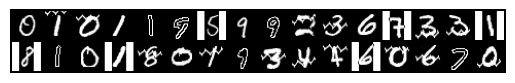

In [86]:
test_loader = DataLoader(test, batch_size=32, shuffle=False)


X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)

plt.imshow(
    make_grid(X.cpu(), nrow=16).permute(1, 2, 0)
)
plt.axis('off')
plt.show()


In [87]:
Z_DIM = 32
TEMP = 0.1
BETA = 50

### cosine

In [88]:
vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=3e-4)
trainer = SimCLRTrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": BETA},
    verbose_period=5,
    device=device,
)

In [89]:
trainer.fit(31, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 208.99it/s]


val_vae_loss=83.317, val_c_loss=0.296, val_s_loss=-3.460


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 206.18it/s]


val_vae_loss=45.924, val_c_loss=0.145, val_s_loss=-4.268


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 210.68it/s]


val_vae_loss=35.849, val_c_loss=0.114, val_s_loss=-4.311


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 207.39it/s]


val_vae_loss=30.767, val_c_loss=0.099, val_s_loss=-4.359


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 212.71it/s]


val_vae_loss=27.584, val_c_loss=0.094, val_s_loss=-4.388


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 220.67it/s]


val_vae_loss=26.142, val_c_loss=0.091, val_s_loss=-4.422


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 218.45it/s]

val_vae_loss=25.198, val_c_loss=0.085, val_s_loss=-4.434


In [90]:
X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)
vae.eval()
X_hat, latent_params, z = vae(X, explicit=True)

interpolate style:


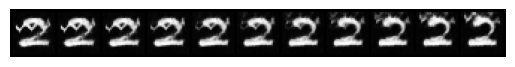

interpolate content:


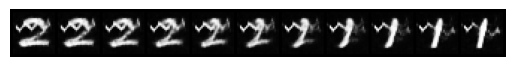

In [91]:
display_util(9, 1, z, vae, 16)

interpolate style:


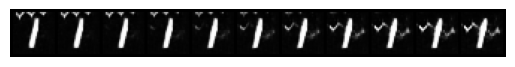

interpolate content:


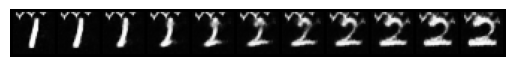

In [92]:
display_util(1, 9, z, vae, 16)


interpolate style:


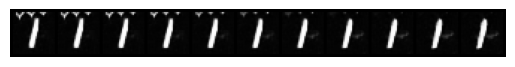

interpolate content:


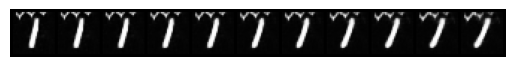

In [93]:
display_util(1, 3, z, vae, int(Z_DIM / 2))

interpolate style:


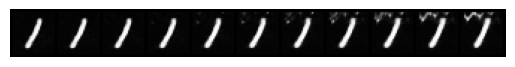

interpolate content:


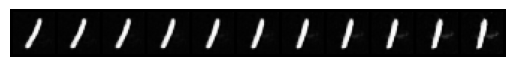

In [94]:
display_util(3, 1, z, vae, int(Z_DIM / 2))

interpolate style:


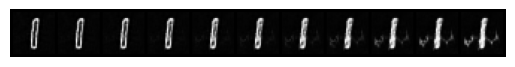

interpolate content:


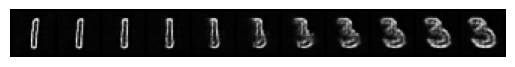

In [95]:
display_util(17, 14, z, vae, int(Z_DIM / 2))

interpolate style:


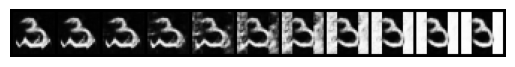

interpolate content:


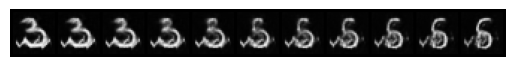

In [96]:
display_util(14, 6, z, vae, int(Z_DIM / 2))

interpolate style:


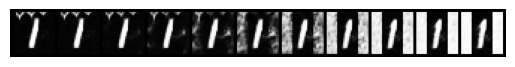

interpolate content:


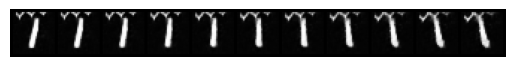

In [97]:
display_util(1, 15, z, vae, int(Z_DIM / 2))

In [100]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)


100%|██████████| 79/79 [00:00<00:00, 314.72it/s]


In [101]:
mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)

In [102]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

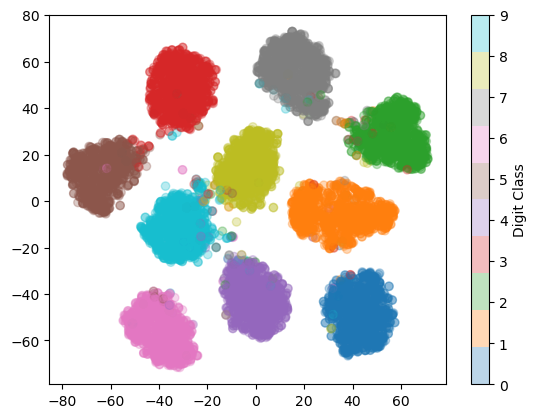

In [103]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [104]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())


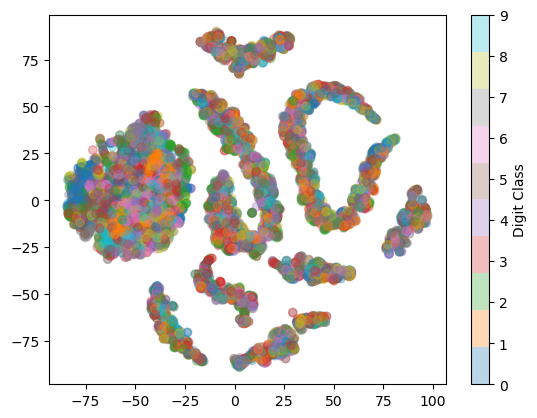

In [105]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

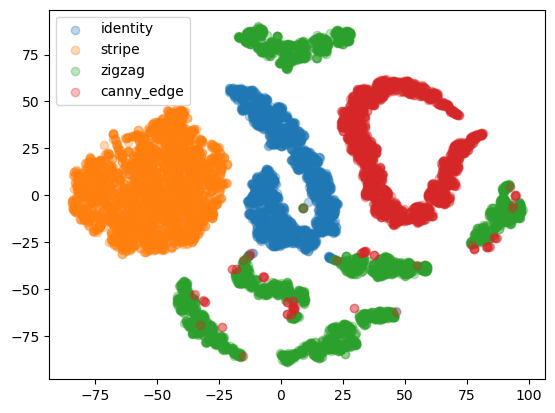

In [139]:
import numpy as np

style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge']
fig, ax = plt.subplots()
for g in range(4):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, label=style_labels[g])
ax.legend()
plt.show()

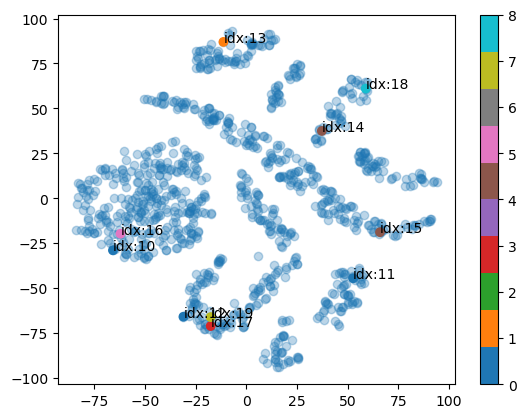

In [64]:
plt.scatter(mu_ss_tsne[:1000, 0], mu_ss_tsne[:1000, 1], alpha=0.3)
plt.scatter(mu_ss_tsne[10:20, 0], mu_ss_tsne[10:20, 1], c=labels[10:20].cpu().numpy(), cmap="tab10")
for i in range(10):
    plt.text(mu_ss_tsne[10+i, 0], mu_ss_tsne[10+i, 1], f"idx:{10+i}", fontsize=10)
plt.colorbar()

In [81]:
idx = 11
display(transforms.ToPILImage()(vae.decode(
    torch.cat([mu_cs[idx], mu_ss[idx]]).view(1, -1)
)[0]))

In [69]:
for i in range(10, 20):
    display(transforms.ToPILImage()(vae.decode(
        torch.cat([mu_cs[19], mu_ss[i]]).view(1, -1)
    )[0]))

### cosine-var-adjust

In [ ]:
vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = SimCLRTrainer(
    vae,
    optimizer,
    sim_fn="cosine-var-adjust",
    hyperparameter={"temperature": TEMP, "beta": BETA},
    verbose_period=5,
    device=device,
)

In [ ]:
trainer.fit(31, dataloader)

In [ ]:
vae.eval()
X_hat, latent_params, z = vae(X, explicit=True)

In [ ]:
display_util(0, 11, z, vae, 16)


In [ ]:
display_util(1, 11, z, vae, 16)


In [ ]:
display_util(5, 0, z, vae, 16)

### arb

In [ ]:
vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = SimCLRTrainer(
    vae,
    optimizer,
    sim_fn="bhattacharyya-coef",
    hyperparameter={"temperature": 0.1, "beta": 10},
    verbose_period=5,
    device=device,
)

In [ ]:
torch.autograd.set_detect_anomaly(False)
trainer.fit(26, dataloader)

In [ ]:
vae.eval()
X_hat, latent_params, z = vae(X, explicit=True)

In [ ]:
display_util(0, 9, z, vae, 16)

In [ ]:
mu_cs = []
mu_ss = []
labels = []
with torch.no_grad():
    for X, label in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)


In [ ]:
mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

In [ ]:
plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())


In [ ]:
plt.scatter(mu_ss_tsne[:1000, 0], mu_ss_tsne[:1000, 1], alpha=0.3)
plt.scatter(mu_ss_tsne[:10, 0], mu_ss_tsne[:10, 1], c=list(range(10)), cmap="tab10")
plt.colorbar()